In [130]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sys
np.set_printoptions(threshold=100000)
import random
import os

#Initialisation
* h_gen is the Function for generating  Channel( Random Initialisation)

In [131]:
random.seed(21)

x = list(range(0, 20))            #
antennaCount=64  
antennaList=np.arange(0,antennaCount)
antennaList=antennaList.reshape(antennaCount,1)
pi = np.pi
trainingCount = 90000
train_h=np.zeros([trainingCount,antennaCount],dtype=complex)
validationCount = 14700
val_h=np.zeros([validationCount,antennaCount],dtype=complex)
testCount = 35000
test_h=np.zeros([testCount,antennaCount],dtype=complex)
tot_set = trainingCount + validationCount + testCount

def h_gen():
  propGain = (np.random.normal(0, 1, 8) + 1j * np.random.normal(0, 1, 8)) / np.sqrt(2)                  #Propagation Gain for Each Multipath Component (Unit Power) 
  phi = np.multiply((2 * pi / 20), random.choices(x, k=8))                                              #Randomly choosing Angle of arrival of different Multipath Components
  phi=phi.reshape([1,8])
  aphi=(1/np.sqrt(8))*np.exp((-1j*2*pi*np.sin(phi))*antennaList)                                        #Response Vector(Function of arrival angles) 
  channel=np.sum(aphi*propGain,axis=1)
  return channel
print(h_gen().shape)


(64,)


Generating Channels for Training, Validation and Testing

In [132]:
for i in range(trainingCount):
  train_h[i,:]=h_gen()
for i in range(testCount):
  test_h[i,:]=h_gen()
for i in range(validationCount):
    val_h[i,:]=h_gen()


*   The Neural Network Cannot Process complex data as such.

*   So the 64 units long Complex data is divided into 64 real and 64 imaginary part vectors and is concateneated to get a 128 unit long Real Vector




In [133]:
train_hvector = np.concatenate((np.real(train_h), np.imag(train_h)), axis=1)
val_hvector = np.concatenate((np.real(val_h), np.imag(val_h)), axis=1)
test_hvector = np.concatenate((np.real(test_h), np.imag(test_h)), axis=1)

print(train_h.shape, val_h.shape, test_h.shape, train_hvector.shape, val_hvector.shape, test_hvector.shape)

(90000, 64) (14700, 64) (35000, 64) (90000, 128) (14700, 128) (35000, 128)


ADC model


1) Preparing Training Data

In [134]:
from collections import Counter
nn=0.5                                                                         #ratio of high Res antennas to Total no antennas
HighResCount =int(nn*antennaCount)   
LowResCount=antennaCount-HighResCount                                                                 
a=[0.6366,0.8825,0.96546,0.990503,0.997501]
alpha=a[2]
snrdb=[0,5,10,15,20,25,30]
snrLinear=np.power(10,np.divide(snrdb,10))

powerTrain=random.choices(snrLinear,k=trainingCount)
powerTrain=np.asarray(powerTrain).reshape([trainingCount,1])                         #Converting and reshaping the list to Numpy array

Covariance Matrix for Quantisation Noise

In [135]:
def qNoiseGen(h,power):
    SampleCount=h.shape[0]
    hLowRes = h[:,HighResCount:]
    Rq=alpha*(1-alpha)*(1+power*(abs(hLowRes)**2))                              #Covariance Matrix
    QuantNoise = (np.random.normal(0, Rq)+ 
                  1j * np.random.normal(0, Rq)) / np.sqrt(2)
    return QuantNoise            

In [136]:
noise1 = (np.random.normal(0,np.ones([ trainingCount,antennaCount])) +
      1j * np.random.normal(0, np.ones([ trainingCount,antennaCount]))) / np.sqrt(2)
y=np.sqrt(powerTrain)*train_h+noise1                                                 # System Model
y_highRes=y[:,:HighResCount]
quantNoisetrain=qNoiseGen(train_h,powerTrain)
y_lowRes=alpha*y[:,HighResCount:]+quantNoisetrain

#Training Set for DI-DNN
train_received=np.concatenate((y_highRes,y_lowRes),axis=1)                      #Recieved Values at the output of the RF chain
train_received=train_received/np.sqrt(powerTrain)                                    #Output of Least Square Estimation
train_receivedVector = np.concatenate((np.real(train_received), np.imag(train_received)), axis=1)             #Unrolling real and imag Axis

print(y.shape,y_highRes.shape,train_received.shape,train_receivedVector.shape)

(90000, 64) (90000, 32) (90000, 64) (90000, 128)


2) Preparing Test data for different SNR

In [137]:
testCountperSNR=5000
noise2 = (np.random.normal(0, np.ones([testCount,antennaCount])) + 
          1j * np.random.normal(0,np.ones([testCount,antennaCount]))) / np.sqrt(2)
y_test=np.zeros([testCount,antennaCount],dtype=complex)
powerTest=np.repeat(snrLinear,testCountperSNR).reshape([testCount,1])           #Repeating Each SNR 4000 times to generate 4000 test samples for each SNR value

y_test=np.sqrt(powerTest)*test_h+noise2
y_highResTest=y_test[:,:HighResCount]
quantNoisetest= qNoiseGen(test_h,powerTest)
y_lowResTest=alpha*y_test[:,HighResCount:]+quantNoisetest

test_received=np.concatenate((y_highResTest,y_lowResTest),axis=1)
test_received/=np.sqrt(powerTest)
test_receivedVector=np.concatenate((np.real(test_received), np.imag(test_received)), axis=1)
print(y_test.shape,test_receivedVector.shape)

(35000, 64) (35000, 128)


In [138]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [139]:
import os
checkpoint_path='/content/gdrive/My Drive/Colab_Notebooks/cp'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Model for DI-DNN

In [140]:
def myModel():
  model = keras.models.Sequential([
      keras.layers.Dense(160, activation='relu',input_shape=(128,)),
      keras.layers.Dense(200, activation='relu'),
      #keras.layers.Dense(400, activation=tf.nn.relu),
      #keras.layers.Dense(400, activation=tf.nn.relu),      
      keras.layers.Dense(160, activation='relu'),
      keras.layers.Dense(128, activation='tanh'),
  ])
  model.compile(optimizer=keras.optimizers.Adam(0.001),loss='mse',metrics='accuracy')
  return model

model =myModel()
#model=keras.models.load_model('/content/drive/My Drive/Research/Models/mimogao')
#model.load_weights(checkpoint_path)
log=model.fit(train_receivedVector,train_hvector/3,epochs=100,verbose=1,batch_size=128)
model.summary()

Epoch 1/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0098 - accuracy: 0.4371
Epoch 2/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0032 - accuracy: 0.5806
Epoch 3/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0029 - accuracy: 0.6001
Epoch 4/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0028 - accuracy: 0.6074
Epoch 5/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0028 - accuracy: 0.6141
Epoch 6/100
704/704 [==============================] - 6s 9ms/step - loss: 0.0027 - accuracy: 0.6149
Epoch 7/100
704/704 [==============================] - 4s 5ms/step - loss: 0.0027 - accuracy: 0.6161
Epoch 8/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0027 - accuracy: 0.6200
Epoch 9/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0027 - accuracy: 0.6210
Epoch 10/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0026 - accura

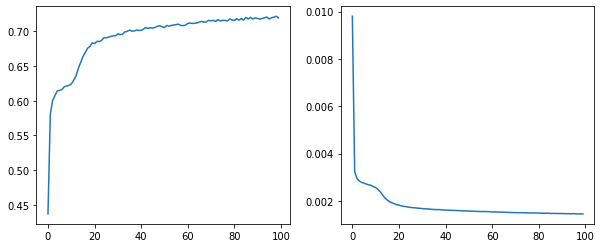

In [141]:
import matplotlib.pyplot as plt

fig,axes= plt.subplots(1,2,figsize=(10,4))
axes[0].plot(log.history['accuracy'])
axes[1].plot(log.history['loss'])

In [142]:
from google.colab import drive
drive.mount('/content/gdrive')
model_name = "mimogao"
model_dir = "/content/gdrive/My Drive/Research/Models/"
dir = os.path.join(model_dir, model_name)
model.save(dir)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Research/Models/mimogao/assets


In [143]:
model=keras.models.load_model(dir)

Finding Mean Square Corresponding to each SNR value

In [144]:
for w in range(len(snrLinear)):
  loss,acc=model.evaluate(test_receivedVector[w*testCountperSNR:(w+1)*testCountperSNR,:],test_hvector[w*testCountperSNR:(w+1)*testCountperSNR,:]/3)


157/157 [==============================] - 0s 1ms/step - loss: 5.4599e-04 - accuracy: 0.7906


In [145]:
h_predict=model.predict(test_receivedVector)
h_retain=3*(h_predict[:,:antennaCount]+1j*h_predict[:,antennaCount:])
diff=(test_h-h_retain)
normsq_test=np.square(np.linalg.norm(test_h,axis=1))
normsq_diff=np.square(np.linalg.norm(diff,axis=1))
error=normsq_diff/normsq_test
nmse=np.zeros(len(snrLinear),)
for w in range(len(snrLinear)):
  nmse[w]= (1/testCountperSNR) * np.sum(error[w*testCountperSNR:(w+1)*testCountperSNR])

print(nmse)
#print(norm_test.shape,norm_diff.shape)
#print(h_predict.shape,h_retain.shape,diff.shape)
#print(diff)
#h_predict-
#for w in range(len(snrLinear)):
 # loss,acc=h_predict(test_recievedVector[:,w*testCountperSNR:(w+1)*testCountperSNR].T,test_hvector[:,w*testCountperSNR:(w+1)*testCountperSNR].T/3,)



[0.1506066  0.05128028 0.02044812 0.01211983 0.00894353 0.00769225
 0.00893393]


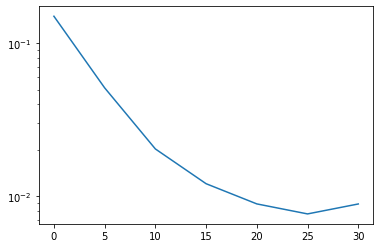

In [146]:
import matplotlib.pyplot as plt
plt.semilogy(snrdb,nmse)

#SIP-DNN: 
Uses the information obtained from the set of High resolution ADCS to train the Network.

1) Training Data for SIP DNN

In [147]:
#Training set for SIP-DNN
trainreceivedRefinement=y_highRes/np.sqrt(powerTrain) 
trainreceivedRefinement=np.concatenate((np.real(trainreceivedRefinement),np.imag(trainreceivedRefinement)),axis=1)
print(y.shape,y_highRes.shape,trainreceivedRefinement.shape)

(90000, 64) (90000, 32) (90000, 64)


In [148]:
train_hRefinement = train_h[:,:HighResCount]
train_hRefinementVector = np.concatenate((np.real(train_hRefinement),np.imag(train_hRefinement)),axis=1)
print(train_h.shape,train_hRefinement.shape,train_hRefinementVector.shape)

(90000, 64) (90000, 32) (90000, 64)


Epoch 1/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0091 - accuracy: 0.5263
Epoch 2/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0039 - accuracy: 0.6614
Epoch 3/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0036 - accuracy: 0.6796
Epoch 4/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0034 - accuracy: 0.6900
Epoch 5/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0032 - accuracy: 0.6933
Epoch 6/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0030 - accuracy: 0.7000
Epoch 7/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0029 - accuracy: 0.7064
Epoch 8/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0028 - accuracy: 0.7114
Epoch 9/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0028 - accuracy: 0.7164
Epoch 10/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0028 - accura

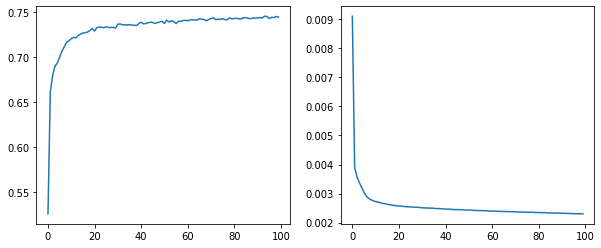

In [149]:
def myModelR():
  model = keras.models.Sequential([
      keras.layers.Dense(120, activation='relu',input_shape=(64,)),
      keras.layers.Dense(200, activation='relu'),
      #keras.layers.Dense(400, activation=tf.nn.relu),
      #keras.layers.Dense(400, activation=tf.nn.relu),      
      keras.layers.Dense(120, activation='relu'),
      keras.layers.Dense(64, activation='tanh'),
  ])
  model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss='mse',metrics='accuracy')
  return model

modelR=myModelR()
logR=modelR.fit(trainreceivedRefinement,train_hRefinementVector/3,verbose=1,epochs=100, batch_size=128)
modelR.summary()
fig,axes= plt.subplots(1,2,figsize=(10,4))
axes[0].plot(logR.history['accuracy'])
axes[1].plot(logR.history['loss'])

In [150]:
test_receivedRef =y_highResTest/np.sqrt(powerTest)
test_receivedVectorRef= np.concatenate( (np.real(test_receivedRef),np.imag(test_receivedRef)), axis=1 )
test_receivedVectorRef.shape

test_hRef= test_h[:,:HighResCount]
test_hRefVect= np.concatenate( (np.real(test_hRef),np.imag(test_hRef)), axis=1 )

In [151]:
for w in range(len(snrLinear)):
  loss,acc=modelR.evaluate(test_receivedVectorRef[w*testCountperSNR:(w+1)*testCountperSNR,:],test_hRefVect[w*testCountperSNR:(w+1)*testCountperSNR,:]/3)


157/157 [==============================] - 0s 1ms/step - loss: 3.4645e-04 - accuracy: 0.8676


MP DNN

Received Signals at low Resolution antennas

In [152]:
train_hMP = train_h[:,HighResCount:]
train_hMPVector = np.concatenate((np.real(train_hMP),np.imag(train_hMP)),axis=1)
print(train_h.shape,train_hMP.shape,train_hMPVector.shape)

(90000, 64) (90000, 32) (90000, 64)


Epoch 1/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0090 - accuracy: 0.5319
Epoch 2/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0041 - accuracy: 0.6589
Epoch 3/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0037 - accuracy: 0.6769
Epoch 4/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0035 - accuracy: 0.6875
Epoch 5/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0033 - accuracy: 0.6945
Epoch 6/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0031 - accuracy: 0.7003
Epoch 7/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0030 - accuracy: 0.7075
Epoch 8/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0029 - accuracy: 0.7144
Epoch 9/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0029 - accuracy: 0.7153
Epoch 10/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0028 - accura

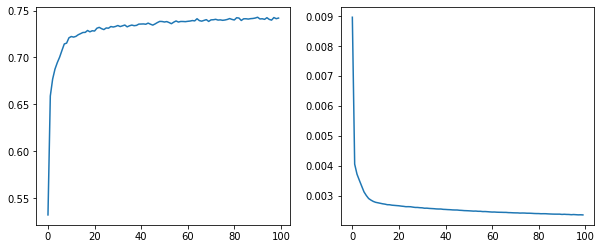

In [153]:
def myModelMP():
  model = keras.models.Sequential([
      keras.layers.Dense(120, activation='relu',input_shape=(64,)),
      keras.layers.Dense(200, activation='relu'),
      #keras.layers.Dense(400, activation=tf.nn.relu),
      #keras.layers.Dense(400, activation=tf.nn.relu),      
      keras.layers.Dense(120, activation='relu'),
      keras.layers.Dense(64, activation='tanh'),
  ])
  model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss='mse',metrics='accuracy')
  return model

modelMP=myModelMP()
logMP=modelMP.fit(trainreceivedRefinement,train_hMPVector/3,verbose=1,epochs=100, batch_size=128)
fig,axes= plt.subplots(1,2,figsize=(10,4))
axes[0].plot(logMP.history['accuracy'])
axes[1].plot(logMP.history['loss'])

In [154]:
test_receivedRef =y_highResTest/np.sqrt(powerTest)
test_receivedVectorRef= np.concatenate( (np.real(test_receivedRef),np.imag(test_receivedRef)), axis=1 )
test_receivedVectorRef.shape

test_hMP= test_h[:,HighResCount:]
test_hMPVect= np.concatenate( (np.real(test_hMP),np.imag(test_hMP)), axis=1 )

In [155]:
for w in range(len(snrLinear)):
  loss,acc=modelMP.evaluate(test_receivedVectorRef[w*testCountperSNR:(w+1)*testCountperSNR,:],test_hMPVect[w*testCountperSNR:(w+1)*testCountperSNR,:]/3)


157/157 [==============================] - 0s 997us/step - loss: 3.2971e-04 - accuracy: 0.8788


In [156]:
h_predict_HighRes=modelR.predict(test_receivedVectorRef)
h_retain_HighRes=3*(h_predict_HighRes[:,:int(h_predict_HighRes.shape[1]/2)]+1j*h_predict_HighRes[:,int(h_predict_HighRes.shape[1]/2):])
h_predict_LowRes=modelMP.predict(test_receivedVectorRef)
h_retain_LowRes=3*(h_predict_LowRes[:,:int(h_predict_LowRes.shape[1]/2)]+1j*h_predict_LowRes[:,int(h_predict_LowRes.shape[1]/2):])

h_predictSIP=np.concatenate((h_retain_HighRes,h_retain_LowRes),axis=1)
print(h_predict_HighRes.shape,h_predict_LowRes.shape,h_retain_HighRes.shape,h_retain_LowRes.shape,h_predictSIP.shape)


diff=(test_h-h_predictSIP)
normsq_test=np.square(np.linalg.norm(test_h,axis=1))
normsq_diff=np.square(np.linalg.norm(diff,axis=1))
error=normsq_diff/normsq_test
nmse=np.zeros(len(snrLinear),)
for w in range(len(snrLinear)):
  nmse[w]= (1/testCountperSNR) * np.sum(error[w*testCountperSNR:(w+1)*testCountperSNR])

print(nmse)


(35000, 64) (35000, 64) (35000, 32) (35000, 32) (35000, 64)
[0.29209501 0.0982548  0.03362094 0.01400385 0.00808711 0.00624131
 0.00578828]


In [157]:
h_predict_HighRes=modelR.predict(test_receivedVectorRef)
h_retain_HighRes=3*(h_predict_HighRes[:,:int(h_predict_HighRes.shape[1]/2)]+1j*h_predict_HighRes[:,int(h_predict_HighRes.shape[1]/2):])
h_predict_LowRes=modelMP.predict(test_receivedVectorRef)
h_retain_LowRes=3*(h_predict_LowRes[:,:int(h_predict_LowRes.shape[1]/2)]+1j*h_predict_LowRes[:,int(h_predict_LowRes.shape[1]/2):])

h_predictSIP=np.concatenate((h_retain_HighRes,h_retain_LowRes),axis=1)
print(h_predict_HighRes.shape,h_predict_LowRes.shape,h_retain_HighRes.shape,h_retain_LowRes.shape,h_predictSIP.shape)

normsq_testHigh =  np.square(np.linalg.norm(test_h[:,:HighResCount],axis=1))
diff_HighRes    =  test_h[:,:HighResCount]-h_retain_HighRes
normsq_diffHigh =  np.square(np.linalg.norm(diff_HighRes,axis=1))
errorHigh           =  normsq_diffHigh/normsq_testHigh



normsq_testLow = np.square(np.linalg.norm(test_h[:,HighResCount:],axis=1))
diff_LowRes=test_h[:,HighResCount:]-h_retain_LowRes
normsq_diffLow =  np.square(np.linalg.norm(diff_LowRes,axis=1))
errorLow           =  normsq_diffLow/normsq_testLow


nmse=np.zeros(len(snrLinear),)
for w in range(len(snrLinear)):
  nmse[w]= (1/testCountperSNR) * np.sum(nn*errorHigh[w*testCountperSNR:(w+1)*testCountperSNR]+
                                        (1-nn)*errorLow[w*testCountperSNR:(w+1)*testCountperSNR])

print(nmse)


(35000, 64) (35000, 64) (35000, 32) (35000, 32) (35000, 64)
[0.29279324 0.09850855 0.03369661 0.0140348  0.00810297 0.00624885
 0.00579528]
